In [1]:
from collections import Counter
import csv
import itertools
import json
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy, skew
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from config import (
    USER_EVAL_PATH_2,
    USER_EVAL_PATH_6,
    USER_EVAL_PATH_10,
    RANDOM_STATE,
    RECOMMENDER_EVAL_PATH,
    TRAIN_DATA_PATH,
    RECOMMENDATIONS_PATH,
    RECOMMENDATIONS_KEY_BASELINE,
    RECOMMENDATIONS_KEY_CF,
    RECOMMENDATIONS_KEY_CB_TITLE,
    RECOMMENDATIONS_KEY_CB_DESCR,
    RECOMMENDATIONS_KEY_CB_COMBI,
    RECOMMENDATIONS_KEY_HYBRID,
    MAIN_RESULTS_ANALYSIS_PATH,
    N_RECOMMENDATIONS,
    RECOMMENDERS,
    EVALUATION_METRICS,
    METADATA_PATH,
)
import utils

### Analyzing main results
Using empirical bootstrapping to measure if the main results are significantly different from each other for each pair of recommenders.

In [10]:
# loading user evaluation results
with open("../" + USER_EVAL_PATH_2, "r") as file:
    eval_2_data = json.load(file)

with open("../" + USER_EVAL_PATH_6, "r") as file:
    eval_6_data = json.load(file)

with open("../" + USER_EVAL_PATH_10, "r") as file:
    eval_10_data = json.load(file)

# loading recommender evaluations results
with open("../" + RECOMMENDER_EVAL_PATH, "r") as file:
    eval_data = json.load(file)

# recommenders to compare
main_recs = [RECOMMENDATIONS_KEY_BASELINE,
             RECOMMENDATIONS_KEY_CF,
             RECOMMENDATIONS_KEY_CB_DESCR,
             RECOMMENDATIONS_KEY_HYBRID]

# evaluation levels
levels = {2: eval_2_data, 
          6: eval_6_data, 
          10: eval_10_data}
metrics = ["hit_rate", "ndcg", "diversity"]

# number of users
n_users = len(eval_2_data[RECOMMENDATIONS_KEY_BASELINE]["ndcg"])

# number of iterations for bootstrapping and seed
n_iterations = 10000
np.random.seed(RANDOM_STATE)

for rec_1, rec_2 in tqdm(itertools.product(main_recs, main_recs), total=len(main_recs)**2):
    # only comparing non-identical recommenders
    if rec_1 != rec_2:
        for level, user_eval_data in levels.items():
            # retrieving evaluation results for each recommender
            eval_data_1 = eval_data[rec_1][str(level)]
            eval_data_2 = eval_data[rec_2][str(level)]

            # retrieving user evaluation results for rec_1
            user_eval_data = user_eval_data[rec_1]

            for metric in metrics:
                # retrieving aggregated evaluation metric @level for each recommender
                metric_val_1 = eval_data_1[metric]
                metric_val_2 = eval_data_2[metric]

                # observed absolute difference
                obs_diff = abs(metric_val_1 - metric_val_2)

                # constant diversity values for baseline
                if rec_1 == RECOMMENDATIONS_KEY_BASELINE and metric == "diversity":
                    metric_vals = [metric_val_1] * n_users
                else:
                    # retrieving metric values from rec_1 as a list
                    metric_dict = user_eval_data[metric]
                    metric_vals = list(metric_dict.values())
                
                # sampling from metric_vals of rec_1
                sample_diffs = []
                for _ in range(n_iterations):
                    sample = random.choices(metric_vals, k=n_users)
                    sample_metric = np.mean(sample)
                    sample_diff = abs(metric_val_1 - sample_metric)
                    sample_diffs.append(sample_diff >= obs_diff)
        
                # computing p-value
                p_val = np.mean(sample_diffs)
                row = [rec_1, rec_2, metric, level, f"{obs_diff:.3f}", f"{p_val:.4f}"]
                with open("../" + MAIN_RESULTS_ANALYSIS_PATH, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow(row)

100%|██████████| 16/16 [1:43:03<00:00, 386.47s/it]


And only for the content-based recommenders:

In [12]:
# recommenders to compare
cb_recs = [RECOMMENDATIONS_KEY_CB_TITLE,
           RECOMMENDATIONS_KEY_CB_DESCR,
           RECOMMENDATIONS_KEY_CB_COMBI]

# evaluation levels
levels = {2: eval_2_data, 
          6: eval_6_data, 
          10: eval_10_data}
metrics = ["hit_rate", "ndcg", "diversity"]

# number of users
n_users = len(eval_2_data[RECOMMENDATIONS_KEY_BASELINE]["ndcg"])

# number of iterations for bootstrapping and seed
n_iterations = 10000
np.random.seed(RANDOM_STATE)

for rec_1, rec_2 in tqdm(itertools.product(cb_recs, cb_recs), total=len(cb_recs)**2):
    # only comparing non-identical recommenders
    if rec_1 != rec_2:
        for level, user_eval_data in levels.items():
            # retrieving evaluation results for each recommender
            eval_data_1 = eval_data[rec_1][str(level)]
            eval_data_2 = eval_data[rec_2][str(level)]

            # retrieving user evaluation results for rec_1
            user_eval_data = user_eval_data[rec_1]

            for metric in metrics:
                # retrieving aggregated evaluation metric @level for each recommender
                metric_val_1 = eval_data_1[metric]
                metric_val_2 = eval_data_2[metric]

                # observed absolute difference
                obs_diff = abs(metric_val_1 - metric_val_2)

                # retrieving metric values from rec_1 as a list
                metric_dict = user_eval_data[metric]
                metric_vals = list(metric_dict.values())
                
                # sampling from metric_vals of rec_1
                sample_diffs = []
                for _ in range(n_iterations):
                    sample = random.choices(metric_vals, k=n_users)
                    sample_metric = np.mean(sample)
                    sample_diff = abs(metric_val_1 - sample_metric)
                    sample_diffs.append(sample_diff >= obs_diff)
        
                # computing p-value
                p_val = np.mean(sample_diffs)
                row = [rec_1, rec_2, metric, level, f"{obs_diff:.3f}", f"{p_val:.3f}"]
                with open("../" + MAIN_RESULTS_ANALYSIS_PATH, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow(row)

100%|██████████| 9/9 [52:12<00:00, 348.08s/it]


### Popularity Bias
Comparison of the distribution of plays per episode in the training data and the distribution of recommendations for each recommender.

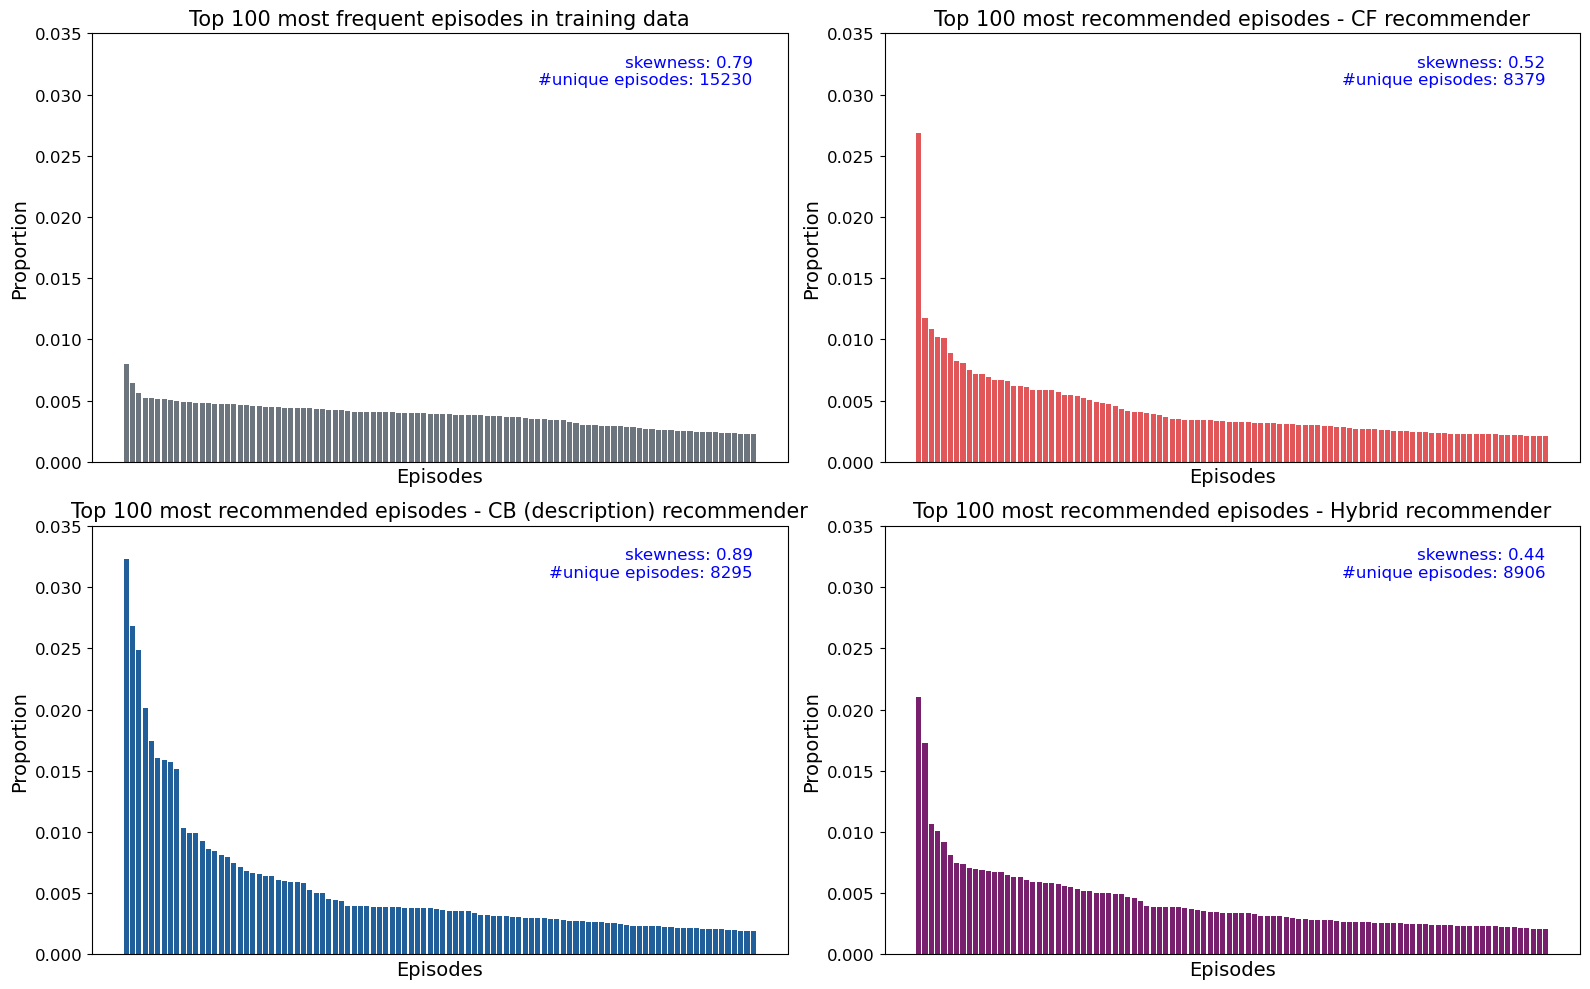

In [13]:
# loading training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# loading recommendations
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    recs_data = json.load(file)

# initializing subplot
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))

# mapping each recommender to its color
color_mapping = {"train": "#6c757d",  
                 RECOMMENDATIONS_KEY_CF: "#E15759",
                 RECOMMENDATIONS_KEY_CB_DESCR: "#215F9A",
                 RECOMMENDATIONS_KEY_HYBRID: "#78206E",
                 }

rec_names = { RECOMMENDATIONS_KEY_CF: "CF",
             RECOMMENDATIONS_KEY_CB_DESCR: "CB (description)",
             RECOMMENDATIONS_KEY_HYBRID: "Hybrid",
             }

# dictionary to store skewness measures 
skew_dict = {}

# number of episodes to show in each bar chart
top_n = 100

for i, (recommender, color) in enumerate(color_mapping.items()):
    row = i // 2
    col = i % 2

    if i == 0:
        # occurences for each episode from the training data
        all_episodes = train_df["prd_number"]
        percentages = all_episodes.value_counts(normalize=True)

        # slicing according to top_n and converting to percentages
        top_episodes = percentages.head(top_n)
        labels = top_episodes.index.astype(str)
        percentages = top_episodes.values

    else:
        # retrieving list of recommendations from recs_data
        recommendations = recs_data[recommender]
        all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

        # counting the occurences for each episode and slicing according to top_n
        episode_counts = Counter(all_episodes)
        top_items = episode_counts.most_common(top_n)

        # extracting labels and values
        labels, values = zip(*top_items)

        # Compute total for relative frequency
        total = sum(episode_counts.values())
        percentages = [(v / total) for v in values]  

        # retrieving short recommender name
        rec_name = rec_names[recommender]

    # computing skewness
    prd_list = [int(prd) for prd in all_episodes]
    skewness = skew(prd_list)
    skew_dict[recommender] = skewness

    # computing number of unique episodes
    n_episodes = len(set(prd_list))

    # plotting the bar chart
    axes[row][col].bar(labels, percentages, color = color)

    # annotating the skewness and the number of unique episodes
    axes[row][col].annotate(f"skewness: {skewness:.2f}\n#unique episodes: {n_episodes}",
                            xy=(0.95, 0.95),
                            xycoords='axes fraction',
                            ha='right', va='top',
                            fontsize=12, color="blue"
                            )

    # formatting the plot
    if i == 0:
        axes[row][col].set_title(f"Top {top_n} most frequent episodes in training data", fontsize=15)
    else:
        axes[row][col].set_title(f"Top {top_n} most recommended episodes - {rec_name} recommender", fontsize=15)
    axes[row][col].set_xlabel("Episodes", fontsize=14)
    axes[row][col].set_ylabel("Proportion", fontsize=14)
    axes[row][col].set_ylim(0, 0.035)
    axes[row][col].set_xticks([],[])
    axes[row][col].tick_params(axis='y', labelsize=12) 

plt.tight_layout()
plt.show()

Measuring if the episode distributions among the recommendations are significantly more or less skewed than the training distribution.

In [14]:
# list of possible episodes to draw and their probabilities from the training data
prd_col = train_df["prd_number"]
episode_counts = Counter(prd_col)
labels, values = zip(*episode_counts.items())

# converting prd numbers to integers
labels = [int(label) for label in labels]

# converting the counts to probabilities
total = sum(episode_counts.values())
probabilities = [v / total for v in values] 

# recommenders to check
recommenders = [RECOMMENDATIONS_KEY_CF,
                RECOMMENDATIONS_KEY_CB_DESCR,
                RECOMMENDATIONS_KEY_HYBRID,
                ]

# bootstrap parameters
n_users = len(set(train_df["user_id"]))
n_samples = n_users * N_RECOMMENDATIONS
n_iterations = 10000
train_skew = skew_dict["train"]
np.random.seed(RANDOM_STATE)

for recommender in recommenders:
    # retrieving skewness of recommendations for recommender
    rec_skew = skew_dict[recommender]
    higher = train_skew < rec_skew
    rec_name = rec_names[recommender]
    skew_diffs = []
    print(f"Comparing training skewness ({train_skew:.3f}) with skewness of {rec_name} recommendations ({rec_skew:.3f}).")

    # printing the null and alternative hypothesis
    print("Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.")
    if higher:
        print("Alternative hypothesis: the skewness of the recommendations is significantly higher than the training skewness.")
    else:
        print("Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.")

    for _ in tqdm(range(n_iterations)):
        # sampling from training distribution
        sample = np.random.choice(labels, size=n_samples, p=probabilities)
        
        # measuring the skewness of the sample
        sample_skew = skew(sample)
        
        if higher:
            skew_diffs.append(sample_skew >= rec_skew)
        else:
            skew_diffs.append(sample_skew <= rec_skew)

    # computing and printing one-sided p-value
    p_value = np.mean(skew_diffs)
    print(f"One-sided p-value: {p_value:.10f}")

Comparing training skewness (0.789) with skewness of CF recommendations (0.521).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.


100%|██████████| 10000/10000 [06:43<00:00, 24.79it/s]


One-sided p-value: 0.0000000000
Comparing training skewness (0.789) with skewness of CB (description) recommendations (0.893).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly higher than the training skewness.


100%|██████████| 10000/10000 [07:05<00:00, 23.51it/s]


One-sided p-value: 0.0000000000
Comparing training skewness (0.789) with skewness of Hybrid recommendations (0.436).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.


100%|██████████| 10000/10000 [06:58<00:00, 23.88it/s]

One-sided p-value: 0.0000000000


### User Bias
Assessing performance metrics against the number of training interactions for each user.

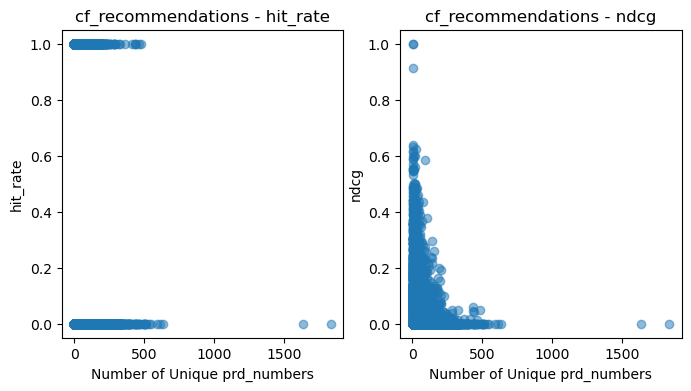

In [6]:
# loading the training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# grouping by user_id and counting the number of unique prd_numbers for each user
user_counts = train_df.groupby("user_id")["prd_number"].nunique()

# loading evaluation metrics for each user
with open("../" + USER_EVAL_PATH, "r") as file:
    data = json.load(file)

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, 
                         n_metrics, 
                         figsize=(4*n_metrics, 4*n_recommenders))

for recommender in RECOMMENDERS:
    # extracting the recommendations for the current recommender
    user_metrics = data[recommender]

    # converting the user_metrics into a DataFrame
    user_metrics_df = pd.DataFrame(user_metrics).reset_index()
    user_metrics_df.columns = ['user_id'] + list(user_metrics.keys())

    # left joining the user_metrics_df with the user_counts
    merged_df = user_metrics_df.merge(user_counts.reset_index(), on='user_id', how='left')

    # plotting each metric against the number of unique prd_numbers
    for i, metric in enumerate(EVALUATION_METRICS):
        ax = axes[i]
        ax.scatter(merged_df["prd_number"], merged_df[metric], alpha=0.5)
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric) 

The data contains two clear outliers representing users with >1500 episodes listened to in the training data. I will discard these two outliers before applying any fit.

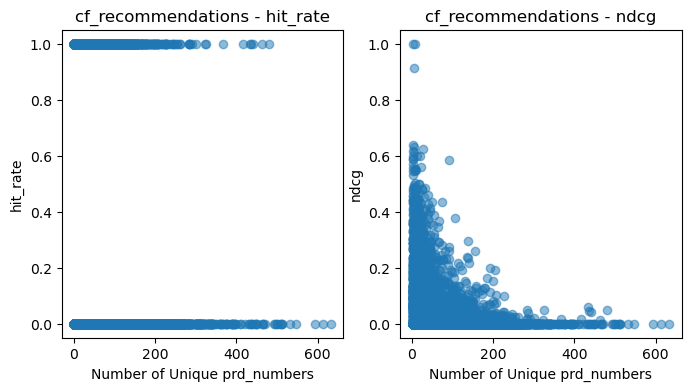

In [7]:
# removing outliers 
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, 
                         n_metrics, 
                         figsize=(4*n_metrics, 4*n_recommenders))

for recommender in RECOMMENDERS:
    # plotting each metric against the number of unique prd_numbers
    for i, metric in enumerate(EVALUATION_METRICS):
        ax = axes[i]
        ax.scatter(merged_df_filtered["prd_number"], merged_df_filtered[metric], alpha=0.5)
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric) 

I think a logistic regression model would be reasonable to fit against the binary hit-rates.  

For the NDCG metric an exponential fit seems to be reasonable.

In [8]:
# function to compute R²
def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

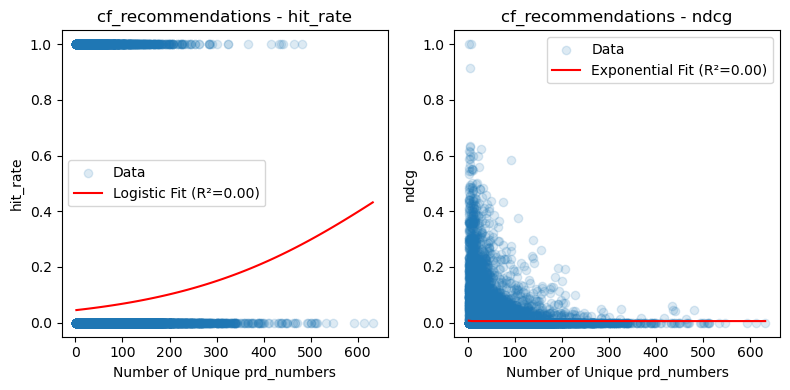

In [15]:
# defining the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def inverse_func(x, a, b, c):
    return a / (x + b) + c

def log_func(x, a, b, c):
    return a * np.log(x + b) + c

# removing outliers
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, n_metrics, figsize=(4 * n_metrics, 4 * n_recommenders))

for r_idx, recommender in enumerate(RECOMMENDERS):
    # plotting each metric against the number of unique prd_numbers
    for m_idx, metric in enumerate(EVALUATION_METRICS):
        ax = axes[r_idx, m_idx] if n_recommenders > 1 else axes[m_idx]
        x = merged_df_filtered["prd_number"].values
        y = merged_df_filtered[metric].values
        ax.scatter(x, y, alpha=0.15, label="Data")
        
        # fitting based on the metric type
        if metric == "hit_rate":
            # logistic regression fit
            x_reshaped = x.reshape(-1, 1)
            logistic_model = LogisticRegression()
            logistic_model.fit(x_reshaped, y)
            x_vals = np.linspace(x_reshaped.min(), x_reshaped.max(), 100).reshape(-1, 1)
            y_vals = logistic_model.predict_proba(x_vals)[:, 1]

            # compute R²
            y_pred = logistic_model.predict_proba(x_reshaped)[:, 1]
            r2 = compute_r2(y, y_pred)

            # plot logistic fit
            ax.plot(x_vals, y_vals, color="red", label=f"Logistic Fit (R²={r2:.2f})")
        
        elif metric == "ndcg":
            # exponential fit
            try:
                popt, _ = curve_fit(exponential_func, x, y)
                x_vals = np.linspace(x.min(), x.max(), 100)
                y_vals = exponential_func(x_vals, *popt)

                # compute R²
                y_pred = exponential_func(x, *popt)
                r2 = compute_r2(y, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="red", label=f"Exponential Fit (R²={r2:.2f})")

            except RuntimeError:
                print(f"Exponential fit failed for {recommender} - {metric}")

        # setting titles and labels
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric)
        ax.legend()

plt.tight_layout()
plt.show()

Normalizing the number of unique prd_numbers:

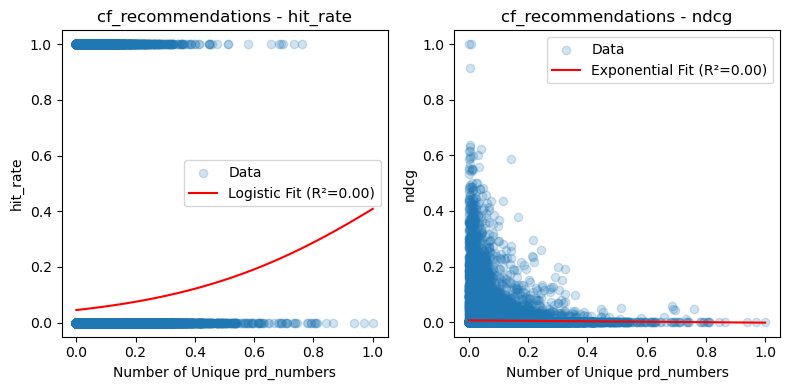

In [10]:
# defining the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# removing outliers
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, n_metrics, figsize=(4 * n_metrics, 4 * n_recommenders))

for r_idx, recommender in enumerate(RECOMMENDERS):
    # plotting each metric against the number of unique prd_numbers
    for m_idx, metric in enumerate(EVALUATION_METRICS):
        ax = axes[r_idx, m_idx] if n_recommenders > 1 else axes[m_idx]
        X = merged_df_filtered["prd_number"]
        x_norm = (X - X.min()) / (X.max() - X.min())
        ax.scatter(x_norm, merged_df_filtered[metric], alpha=0.2, label="Data")
        
        if metric == "hit_rate":
            # logistic regression fit
            X = merged_df_filtered["prd_number"].values.reshape(-1, 1)
            x_norm = (X - X.min()) / (X.max() - X.min())  
            y = merged_df_filtered[metric].values
            logistic_model = LogisticRegression()
            logistic_model.fit(x_norm, y)
            x_vals = np.linspace(x_norm.min(), x_norm.max(), 100).reshape(-1, 1)
            y_vals = logistic_model.predict_proba(x_vals)[:, 1]
            
            # compute R²
            y_pred = logistic_model.predict_proba(x_norm)[:, 1]
            r2 = compute_r2(y, y_pred)
            
            # plot logistic fit
            ax.plot(x_vals, y_vals, color="red", label=f"Logistic Fit (R²={r2:.2f})")
        
        elif metric == "ndcg":
            # exponential fit
            x_data = merged_df_filtered["prd_number"].values
            x_norm = (x_data - x_data.min()) / (x_data.max() - x_data.min())  
            y_data = merged_df_filtered[metric].values
            
            try:
                popt, _ = curve_fit(exponential_func, x_norm, y_data)
                x_vals = np.linspace(x_norm.min(), x_norm.max(), 100)
                y_vals = exponential_func(x_vals, *popt)
                
                # compute R²
                y_pred = exponential_func(x_norm, *popt)
                r2 = compute_r2(y_data, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="red", label=f"Exponential Fit (R²={r2:.2f})")
            except RuntimeError:
                print(f"Exponential fit failed for {recommender} - {metric}")
        
        # setting titles and labels
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric)
        ax.legend()

plt.tight_layout()
plt.show()

### Group Fairness of Genres
Distribution of genres in the training data and the recommendations:

In [15]:
# loading training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# loading episode metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# translating the genres to English
genre_translations = {"Aktualitet": "Current affairs",
                      "Børn": "Children",
                      "Dokumentar": "Documentary",
                      "Fakta og debat": "Factual & debate",
                      "Historie": "History",
                      "Kor og orkestre": "Choirs & orchestras",
                      "Kultur": "Culture",
                      "Livsstil": "Lifestyle",
                      "Musik": "Music",
                      "NN": "NN", 
                      "Nyheder": "News",
                      "Sport": "Sports",
                      "Underholdning": "Entertainment",
                      "Unge": "Youth"}
meta_df["genre"] = meta_df["genre"].replace(genre_translations)

# joining on metadata
train_w_meta_df = train_df.merge(meta_df.reset_index(), on="prd_number", how="left")

# loading recommendations
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    data = json.load(file)

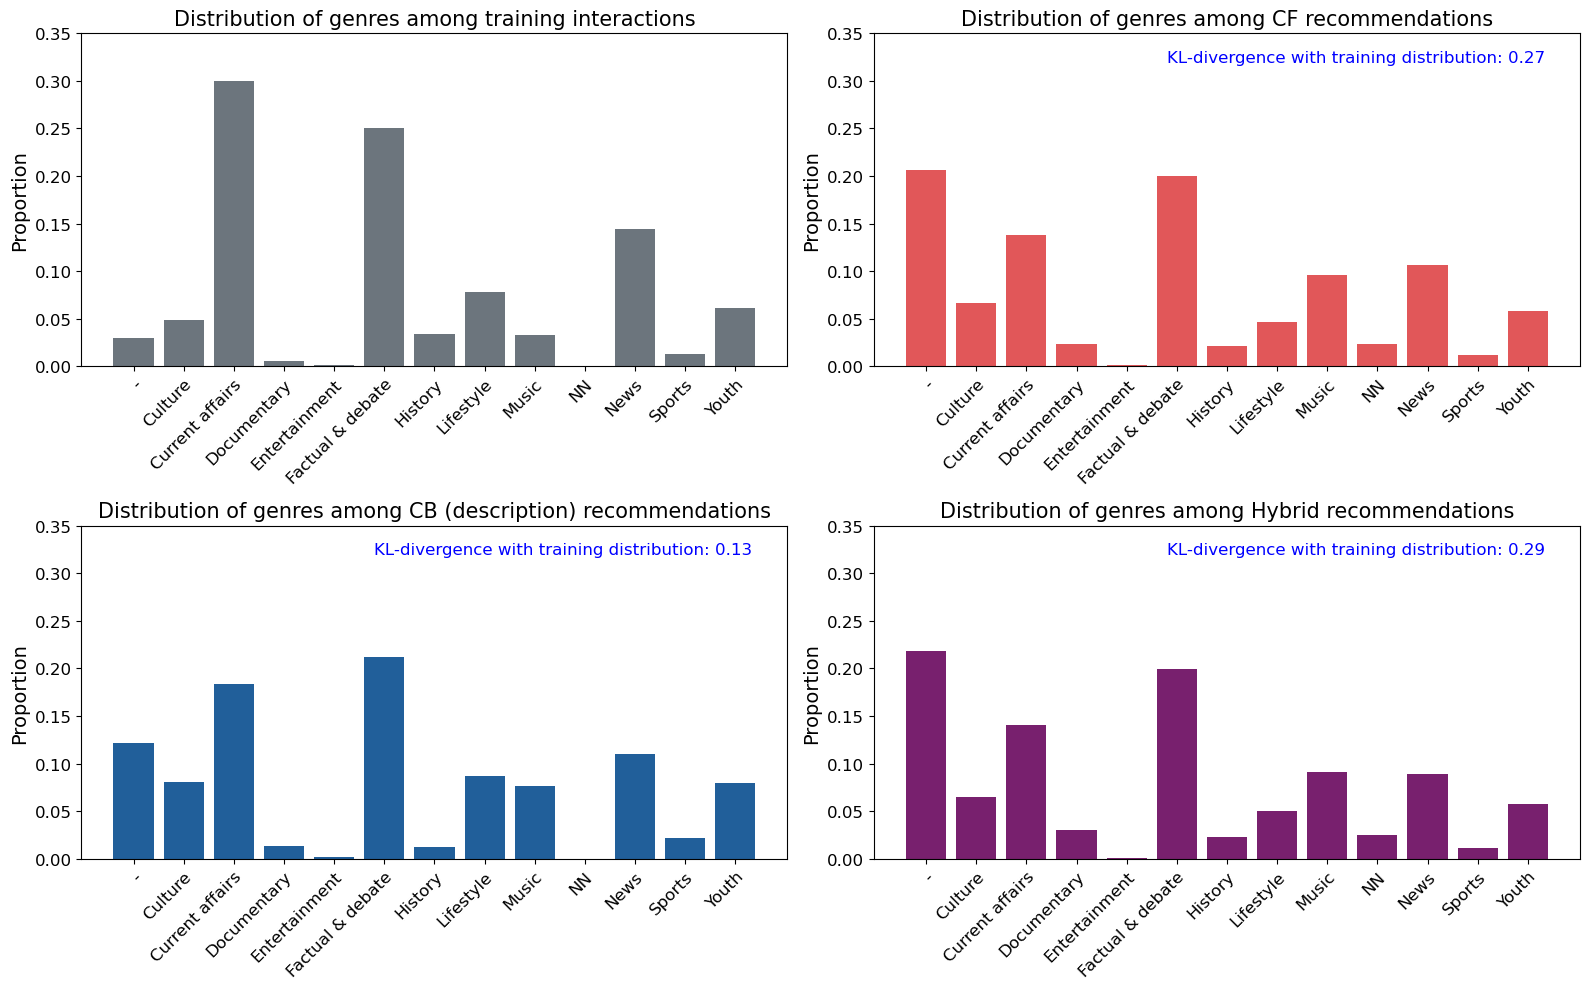

In [17]:
# initializing subplot
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))

# mapping each recommender to its color
color_mapping = {"train": "#6c757d",  
                 RECOMMENDATIONS_KEY_CF: "#E15759",
                 RECOMMENDATIONS_KEY_CB_DESCR: "#215F9A",
                 RECOMMENDATIONS_KEY_HYBRID: "#78206E",
                 }

rec_names = { RECOMMENDATIONS_KEY_CF: "CF",
             RECOMMENDATIONS_KEY_CB_DESCR: "CB (description)",
             RECOMMENDATIONS_KEY_HYBRID: "Hybrid",
             }

# dictionary to store KL-divergences
kl_dict = {}

for i, (recommender, color) in enumerate(color_mapping.items()):
    row = i // 2
    col = i % 2
    
    if i == 0:
        # genre distribution of training interactions
        train_genre_distr = train_w_meta_df["genre"].value_counts(normalize=True)
        train_genre_distr_sorted = train_genre_distr.sort_index()
        genres = train_genre_distr_sorted.index.astype(str)
        percentages = train_genre_distr_sorted.values
        training_distr = percentages
    
    else:
        # retrieving list of recommendations from recs_data
        recommendations = recs_data[recommender]
        all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

        # constructing dataframe
        df = pd.DataFrame({"prd_number": all_episodes})

        # joining metadata onto the dataframe
        df_w_meta = df.merge(meta_df.reset_index(), on="prd_number", how="left")

        # genre distribution of recommendations
        rec_genre_distr = df_w_meta["genre"].value_counts(normalize=True)
        rec_genre_distr_sorted =  rec_genre_distr.sort_index()
        genres = rec_genre_distr_sorted.index.astype(str)
        percentages = rec_genre_distr_sorted.values

        # computing KL-divergence
        kl_div = entropy(training_distr, percentages)
        kl_dict[recommender] = kl_div
        
        # annotating the skewness and the number of unique episodes
        axes[row][col].annotate(f"KL-divergence with training distribution: {kl_div:.2f}",
                                xy=(0.95, 0.95),
                                xycoords='axes fraction',
                                ha='right', va='top',
                                fontsize=12, color="blue"
                                )
            
        # retrieving recommender name
        rec_name = rec_names[recommender]

    # measuring the distribution
    if i == 0:
        axes[row][col].set_title("Distribution of genres among training interactions", fontsize=15)
    else:
        axes[row][col].set_title(f"Distribution of genres among {rec_name} recommendations", fontsize=15)
    axes[row][col].bar(range(len(genres)), percentages, color=color)
    axes[row][col].set_ylabel("Proportion", fontsize=14)
    axes[row][col].set_ylim(0, 0.35)
    axes[row][col].set_xticks(range(len(genres)))  
    axes[row][col].set_xticklabels(genres, rotation=45, ha='right', rotation_mode='anchor', fontsize=12)  
    axes[row][col].tick_params(axis='y', labelsize=12) 

plt.tight_layout()

Measuring if the KL-divergences signify that the genre distributions of the recommendations are significantly different from the genre distribution of the training interactions.

In [18]:
# genre distribution of training interactions
train_genre_distr = train_w_meta_df["genre"].value_counts(normalize=True)
train_genre_distr_sorted = train_genre_distr.sort_index()
genres = train_genre_distr_sorted.index.astype(str)
probabilities = train_genre_distr_sorted.values

# recommenders to check
recommenders = [RECOMMENDATIONS_KEY_CF,
                RECOMMENDATIONS_KEY_CB_DESCR,
                RECOMMENDATIONS_KEY_HYBRID
                ]

# bootstrap parameters
n_users = len(set(train_df["user_id"]))
n_samples = n_users * N_RECOMMENDATIONS
n_iterations = 10000
train_skew = skew_dict["train"]
np.random.seed(RANDOM_STATE)

for recommender in recommenders:
    # retrieving skewness of recommendations for recommender
    rec_kl = kl_dict[recommender]
    rec_name = rec_names[recommender]
    kl_diffs = []
    print(f"Testing if the genre distribution of {rec_name} recommendations is significantly different from the genre distribution of the training interactions.")
    print(f"Observed KL-divergence for {rec_name} recommender: {rec_kl:.2f}")

    # printing the null and alternative hypothesis
    print(f"Null hypothesis: the genre distribution of the {rec_name} recommendations is the same as the genre distribution of the training interactions.")
    print(f"Alternative hypothesis: the genre distribution of the {rec_name} recommendations is different from the genre distribution of the training interactions.")
    print(f"In other words: the observed KL-divergence is large enough to imply that")

    for _ in tqdm(range(n_iterations)):
        # sampling from training distribution
        sample = np.random.choice(genres, size=n_samples, p=probabilities)

        # computing sampling distribution
        counts = Counter(sample)
        total = sum(counts.values())
        distribution = dict(sorted((k, v / total) for k, v in counts.items()))
        distribution = list(distribution.values())

        # measuring the skewness of the sample
        sample_kl = entropy(probabilities, distribution)
        kl_diffs.append(sample_kl >= rec_kl)

    # computing and printing one-sided p-value
    p_value = np.mean(kl_diffs)
    print(f"One-sided p-value: {p_value:.10f}")

Testing if the genre distribution of CF recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for CF recommender: 0.27
Null hypothesis: the genre distribution of the CF recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the CF recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [05:03<00:00, 33.00it/s]


One-sided p-value: 0.0000000000
Testing if the genre distribution of CB (description) recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for CB (description) recommender: 0.13
Null hypothesis: the genre distribution of the CB (description) recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the CB (description) recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [05:04<00:00, 32.85it/s]


One-sided p-value: 0.0000000000
Testing if the genre distribution of Hybrid recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for Hybrid recommender: 0.29
Null hypothesis: the genre distribution of the Hybrid recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the Hybrid recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [05:09<00:00, 32.35it/s]

One-sided p-value: 0.0000000000
